# Codes - Sleep Quality Analysis with Machine Learning

This document contains the codes used in the analysis.

## Exploratory Analysis

In [32]:
# Importing libraries
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVR 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

### sleepdata.csv (Dataset 1)

In [33]:
# Dataset
sleepdata = pd.read_csv("sleepdata.csv", sep = ";")

row, col = sleepdata.shape

print("The first dataset contains", row, "rows and", col, "columns.")

The first dataset contains 887 rows and 8 columns.


In [34]:
sleepdata.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0


In [23]:
sleepdata.dtypes

Start                object
End                  object
Sleep quality        object
Time in bed          object
Wake up              object
Sleep Notes          object
Heart rate          float64
Activity (steps)      int64
dtype: object

In [24]:
sleepdata.isnull().sum(axis = 0)

Start                 0
End                   0
Sleep quality         0
Time in bed           0
Wake up             641
Sleep Notes         235
Heart rate          725
Activity (steps)      0
dtype: int64

### sleepdata_2.csv (Dataset 2)

In [35]:
# Dataset
sleepdata2 = data = pd.read_csv("sleepdata_2.csv", sep = ";")

row, col = sleepdata2.shape

print("The second dataset contains", row, "rows and", col, "columns")

The second dataset contains 921 rows and 21 columns


In [36]:
sleepdata2.isnull().sum(axis = 0)

Start                            0
End                              0
Sleep Quality                    0
Regularity                       0
Mood                           921
Heart rate (bpm)                 0
Steps                            0
Alarm mode                       0
Air Pressure (Pa)              429
City                           434
Movements per hour               0
Time in bed (seconds)            0
Time asleep (seconds)            0
Time before sleep (seconds)      0
Window start                    80
Window stop                     80
Did snore                        0
Snore time                       0
Weather temperature (°C)         0
Weather type                     0
Notes                          912
dtype: int64

## Data Pre-processing

In [37]:
data_cleaned = sleepdata.copy()

# Dropping columns "End", "Wake up" "Heart rate"
data_cleaned = data_cleaned.drop(["End", "Wake up", "Heart rate"], axis = 1)

# Dropping rows where "Sleep quality", "Sleep Notes" or is NA
data_cleaned = data_cleaned.dropna(subset = ["Sleep quality", "Sleep Notes"])

# Droppin rows where "Activity (steps)" is zero
data_cleaned.drop(data_cleaned[data_cleaned["Activity (steps)"] == 0].index, inplace = True)

# Modifying "Time in bed" into minutes
data_cleaned = data_cleaned.reset_index(drop=True)

for row in range(data_cleaned.shape[0]):
    str_time = data_cleaned["Time in bed"][row]
    if str_time[1] == ":":
        data_cleaned["Time in bed"][row] = int(int(data_cleaned["Time in bed"][row][0]) * 60 + int(data_cleaned["Time in bed"][row][2:4]))
    else:
        data_cleaned["Time in bed"][row] = int(data_cleaned["Time in bed"][row][0:2]) * 60 + int(data_cleaned["Time in bed"][row][3:5])

# Modifying "Sleep quality" into an integer and "Time in bed into a numeric"
data_cleaned["Sleep quality"] = data_cleaned["Sleep quality"].apply(lambda row: int(row[:-1]))
data_cleaned["Time in bed"] = pd.to_numeric(data_cleaned["Time in bed"])

# Creating "Late to Bed" feature
data_cleaned["Late to bed"] = pd.to_datetime(data_cleaned["Start"]).dt.hour.map(lambda x: int(x < 6 and x >= 0))

# Creating "Weekend" and "Weekday" features
data_cleaned["Start"] = pd.to_datetime(data_cleaned["Start"]).dt.date
data_cleaned["Weekend"] = pd.to_datetime(data_cleaned["Start"]).dt.dayofweek
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
data_cleaned["Weekday"] = data_cleaned.Weekend.map(days)
data_cleaned["Weekend"] = data_cleaned["Weekend"].apply(lambda row: int(row == 4 or row == 5 or row == 6))

# The number of remaining rows
print("The number of remaining rows is", data_cleaned.shape[0])

# Showing the results
data_cleaned.head()

/tmp/ipykernel_146/683748972.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned["Time in bed"][row] = int(int(data_cleaned["Time in bed"][row][0]) * 60 + int(data_cleaned["Time in bed"][row][2:4]))
/tmp/ipykernel_146/683748972.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned["Time in bed"][row] = int(data_cleaned["Time in bed"][row][0:2]) * 60 + int(data_cleaned["Time in bed"][row][3:5])


The number of remaining rows is 254


,Start,Sleep quality,Time in bed,Sleep Notes,Activity (steps),Late to bed,Weekend,Weekday
0,2016-08-17,78,453,Ate late:Drank coffee:Worked out,7200,0,0,Wednesday
1,2016-08-18,36,504,Drank coffee:Worked out,3444,0,0,Thursday
2,2016-08-20,56,628,Drank coffee,7901,0,1,Saturday
3,2016-08-21,52,491,Drank coffee:Drank tea,3786,0,1,Sunday
4,2016-08-22,35,489,Drank coffee:Worked out,2668,0,0,Monday


In [38]:
# Encoding Sleep Notes into variables
data_cleaned["Sleep Notes"].value_counts()

Drank coffee:Drank tea                             63
Drank coffee:Drank tea:Worked out                  61
Drank tea                                          38
Drank tea:Worked out                               34
Drank coffee:Worked out                            22
Drank coffee                                       19
Drank coffee:Drank tea:Stressful day                4
Drank coffee:Drank tea:Stressful day:Worked out     3
Ate late:Drank coffee:Worked out                    2
Drank tea:Stressful day:Worked out                  2
Drank coffee:Stressful day:Worked out               2
Ate late:Drank coffee:Drank tea:Worked out          2
Drank coffee:Stressful day                          1
Ate late:Drank coffee:Drank tea                     1
Name: Sleep Notes, dtype: int64

In [39]:
# Mapping notes with the new column names
dict_names = {"coffee": "Coffee", "tea": "Tea", "Worked": "Working out", "Ate late": "Late eating", "Stressful": "Stress"}

# Making the notes into binary variables
def binarizeNotes(note_name, new_name):
    data_cleaned[new_name] = data_cleaned["Sleep Notes"].apply(lambda row: int(note_name in row))

for note_name, new_name in dict_names.items():
    binarizeNotes(note_name, new_name)

# Dropping "Sleep Notes"
data_cleaned = data_cleaned.drop(["Sleep Notes"], axis = 1)

data_cleaned.head()

,Start,Sleep quality,Time in bed,Activity (steps),Late to bed,Weekend,Weekday,Coffee,Tea,Working out,Late eating,Stress
0,2016-08-17,78,453,7200,0,0,Wednesday,1,0,1,1,0
1,2016-08-18,36,504,3444,0,0,Thursday,1,0,1,0,0
2,2016-08-20,56,628,7901,0,1,Saturday,1,0,0,0,0
3,2016-08-21,52,491,3786,0,1,Sunday,1,1,0,0,0
4,2016-08-22,35,489,2668,0,0,Monday,1,0,1,0,0


## Plots

Max sleep quality: 100 Min sleep quality: 33


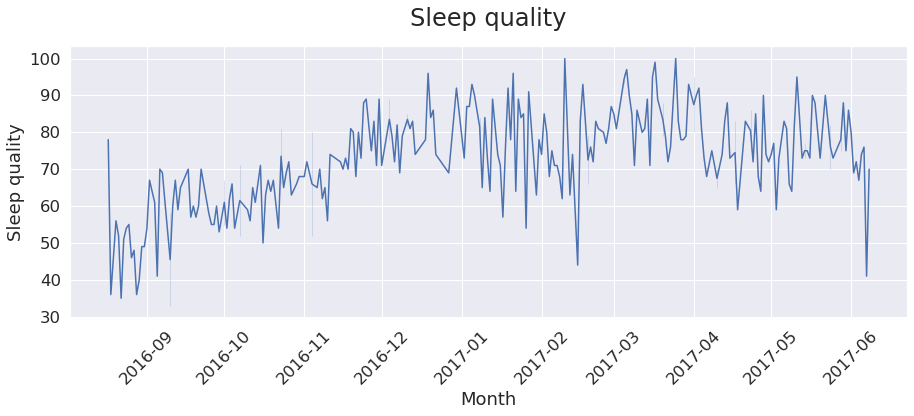

In [40]:
plt.figure(figsize=(15,5))

sns.lineplot(y = data_cleaned["Sleep quality"], x = data_cleaned["Start"])

plt.title("Sleep quality", pad=20, fontsize=24)
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.savefig('Sleep_quality_trendline.png')
print("Max sleep quality:", max(data_cleaned["Sleep quality"]), "Min sleep quality:", min(data_cleaned["Sleep quality"]))
plt.show()

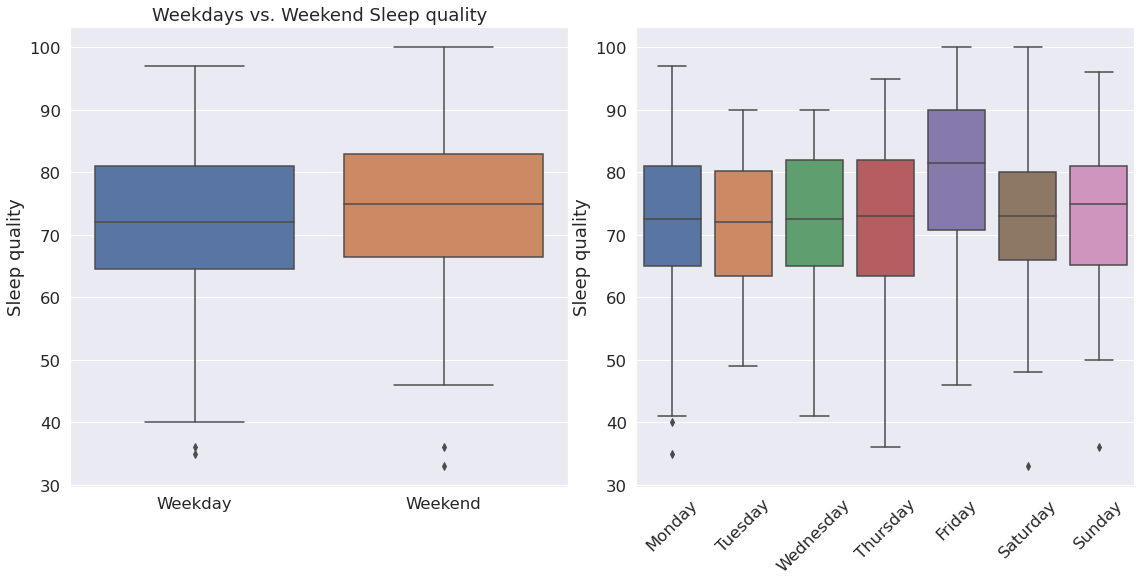

In [41]:
# Initialize a figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Make a boxplot with seaborn
sns.boxplot(x=data_cleaned['Weekend'], y=data_cleaned['Sleep quality'], ax=ax1)
ax1.set_title("Weekdays vs. Weekend Sleep quality")
ax1.set_xticklabels(["Weekday", "Weekend"])
ax1.set(xlabel=None)

order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Make a boxplot with seaborn
sns.boxplot(x=data_cleaned['Weekday'], y=data_cleaned['Sleep quality'], ax=ax2, order = order)
ax2.set_xlabel("Weekday")
ax2.set(xlabel=None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45)
plt.savefig('Sleep_quality_weekday.png')
plt.show()

In [42]:
data_cleaned = data_cleaned.drop(["Start", "Weekday"], axis = 1)

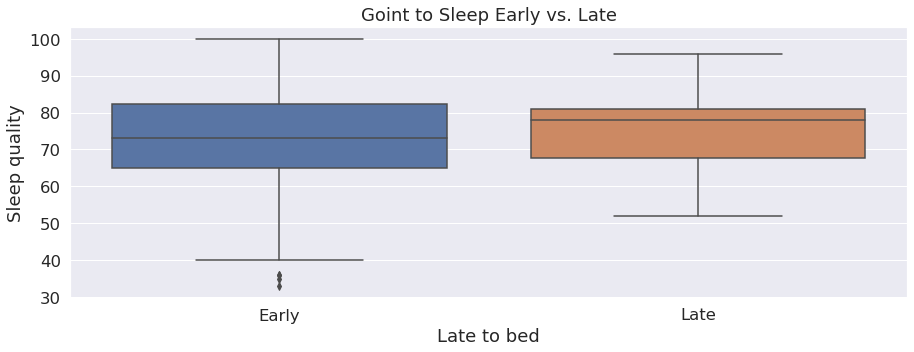

In [43]:
# Initialize a figure
plt.figure(figsize=(15,5))

# Make a boxplot with seaborn
ax = sns.boxplot(x=data_cleaned['Late to bed'], y=data_cleaned['Sleep quality'])
plt.title("Goint to Sleep Early vs. Late")
ax.set_xticklabels(["Early", "Late"])
plt.savefig('Sleep_quality_late.png')
plt.show()

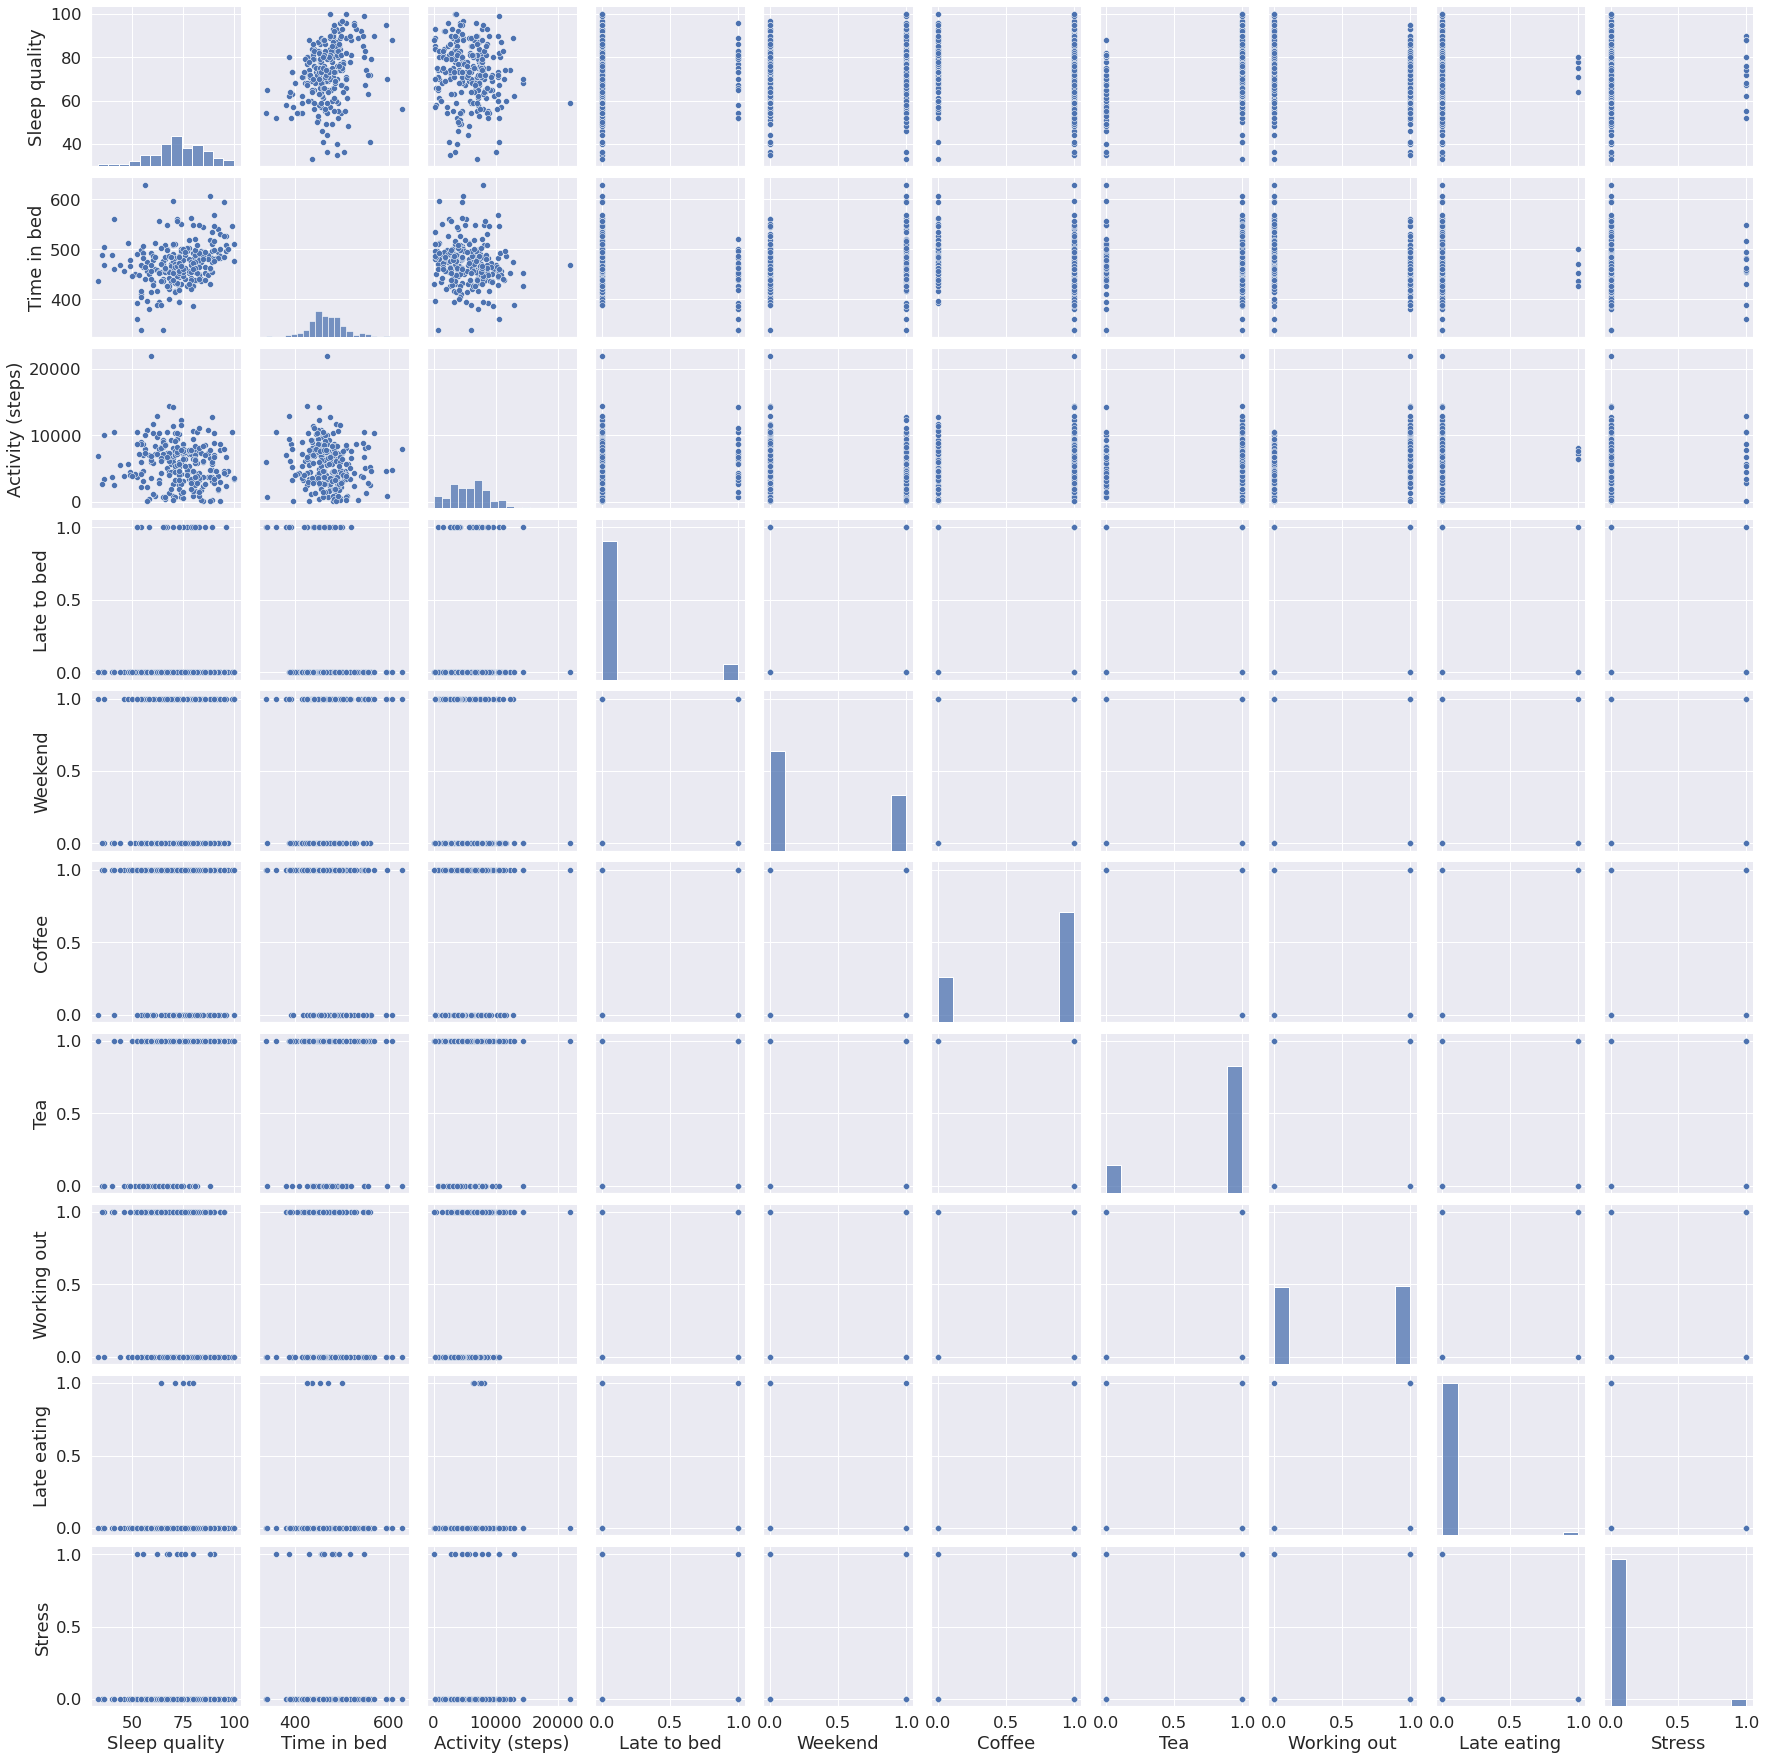

In [44]:
sns.pairplot(data_cleaned)
plt.savefig('Pairplot.png')
plt.show()

## Feature Selection

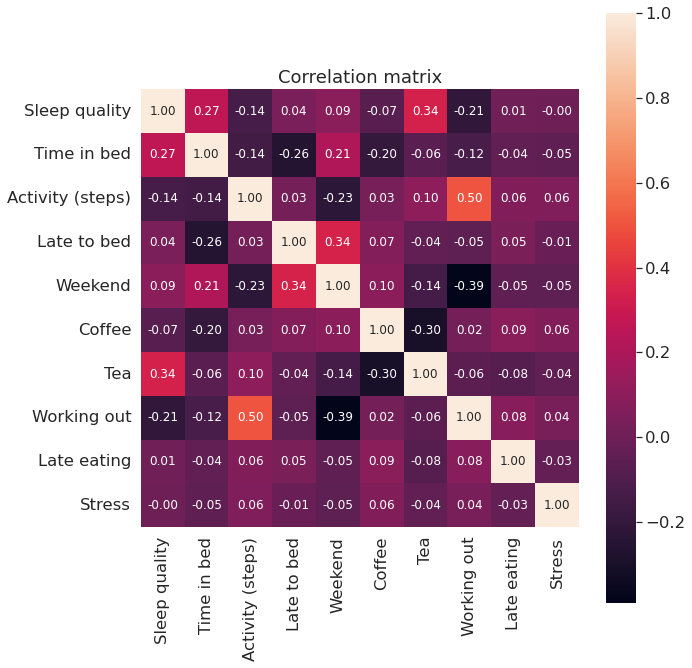

In [45]:
# Covariance matrix
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(data_cleaned.corr(),
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12})
plt.title('Correlation matrix')
plt.tight_layout() 
plt.savefig('Correlation_matrix.png')
plt.show() 

In [46]:
y = data_cleaned.iloc[:, 0]
X = data_cleaned.iloc[:, 1:]

# Scaling
scaler = StandardScaler()
X_names = list(X.columns.values)
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = X_names

X_train, X_test = data_cleaned.iloc[:230, 1:], data_cleaned.iloc[230:, 1:]
y_train, y_test = data_cleaned.iloc[:230, 0], data_cleaned.iloc[230:, 0]

# Regressors
lin_reg = LinearRegression()
svr = SVR()

# Sequential feature selection
lin_reg_sfs = SequentialFeatureSelector(lin_reg)
svr_sfs = SequentialFeatureSelector(svr)

lin_reg_sfs.fit(X_train, y_train)
svr_sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), direction = "backward")
SequentialFeatureSelector(estimator=SVR(), direction = "backward")

print("The proposed variables with the linear regression are:", lin_reg_sfs.get_feature_names_out())
print("The proposed variables with the support vector regressor are:", svr_sfs.get_feature_names_out())

The proposed variables with the linear regression are: ['Time in bed' 'Late to bed' 'Tea' 'Working out']
The proposed variables with the support vector regressor are: ['Tea' 'Working out' 'Late eating' 'Stress']


## Predicting sleep quality with machine learning

In [54]:
X_train2, X_test2 = X_train[['Time in bed', 'Late to bed', 'Tea', 'Working out']], X_test[['Time in bed', 'Late to bed', 'Tea', 'Working out']]
X_train3, X_test3 = X_train[['Tea', 'Working out', 'Late eating', 'Stress']], X_test[['Tea', 'Working out', 'Late eating', 'Stress']]

training_sets = [(X_train, X_test), (X_train2, X_test2), (X_train3, X_test3)]

# Score tables
scores = [np.zeros((2, 3)) for i in range(3)]

def predict(model, index):
    i = 0
    for set in training_sets:
        reg = model
        model.fit(set[0], y_train)
        y_pred = model.predict(set[1])
        scores[i][0,index] = int(mean_squared_error(y_pred, list(y_test)))
        scores[i][1,index] = round(r2_score(y_pred, list(y_test)), 2)
        i += 1
        


# Linear regression
predict(LinearRegression(), 0)
        
# SVR with 'rbf' kernel
predict(SVR(kernel = "rbf"), 1)
        
# SVR with 'poly' kernel
predict(SVR(kernel = "poly"), 2)
    
for table in scores:    
    table = pd.DataFrame(table)
    table.columns = ["Linear", "SVR rbf", "SVR poly"]
    table.index = ["MSE", "R2 score"]
    display(table)

,Linear,SVR rbf,SVR poly
MSE,197.0,102.00,101.00
R2 score,-1.8,-36.34,-116.05


,Linear,SVR rbf,SVR poly
MSE,199.00,102.00,101.00
R2 score,-2.04,-227.76,-15.12


,Linear,SVR rbf,SVR poly
MSE,218.00,167.00,199.00
R2 score,-3.14,-4.95,-3.74
